# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

# Task to be performed:
1. We need to work with 2 versions of SVM
a. Linear kernel
b. RBF kernel
2. When we are working with linear kernel, if want a computationally less expensive
algorithm we can go with ‘SGDClassifier’ with hinge loss.
3. When we are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
score, we might need to use CalibratedClassifierCV
4. Similarly, like kdtree of knn, when we are working with RBF kernel it's better to reduce
the number of dimensions.
5. When we are working on the linear kernel with BOW or TFIDF please print the best
feature for each of the positive and negative classes.
6. Try to introduce some features, and work more on featurizations so that our model can
do better.

In [1]:
import numpy 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re 
import sqlite3

C:\Users\manish dogra\Documents\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
con = sqlite3.connect("./amazon-fine-food-reviews/database.sqlite")
data = pd.read_sql_query('''
SELECT *
FROM REVIEWS
WHERE SCORE != 3''', con)
data.shape

(525814, 10)

# Data Cleaning

In [3]:
data = data[data.HelpfulnessNumerator <= data.HelpfulnessDenominator]
data.shape

(525812, 10)

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [4]:
data['Score'] = data["Score"].apply(lambda x: "positive" if x > 3 else "negative")
sorted_data = data.sort_values('ProductId',axis = 0, inplace = False, kind = 'quicksort',ascending = True)
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci..."
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books..."
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,positive,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...


In [5]:
filtered_data = sorted_data.drop_duplicates(subset = {'UserId','ProfileName','Time'} ,keep = 'first', inplace = False)
filtered_data.shape

(328770, 10)

In [6]:
filtered_data['Score'].value_counts()

positive    275650
negative     53120
Name: Score, dtype: int64

In [7]:
final = filtered_data.copy()

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\manish
[nltk_data]     dogra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
stop = set(stopwords.words("english"))
st = PorterStemmer()
st.stem('burned')

'burn'

##  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
def cleanhtml(sent):
    cleanr = re.compile('<.*?>')
    cleaned = re.sub(cleanr,' ',sent)
    return cleaned
def cleanpunc(sent):
    clean = re.sub(r'[?|!|$|#|\'|"|:]',r'',sent)
    clean = re.sub(r'[,|(|)|.|\|/]',r' ',clean)
    return clean

In [11]:
i=0
all_positive_reviews =[]
all_negative_reviews = []
final_string = []
stem_data = " "
for p in final['Text'].values:
    filtered_sens = []#filtered word
    p = cleanhtml(p)
    for w in p.split():
       # print(w)
        punc = cleanpunc(w)
        for s in punc.split():
            #print(w)
            if (s.isalpha()) & (len(s)>2):
                if s.lower() not in stop:
                    stem_data = (st.stem(s.lower())).encode('utf8')
                    #can we use lemmatizer and stemming altogether??
                    filtered_sens.append(stem_data)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_reviews.append(stem_data)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_reviews.append(stem_data)
                else:
                    continue
            else:
                continue
    #print(filtered_sens)
    str1 = b" ".join(filtered_sens)
    #print(str1)
    final_string.append(str1)
    i+=1

In [12]:
final['CleanedText'] = final_string
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci...",b'charm rhyme book describ circumst eat dont c...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...,b'one best children book ever written mini ver...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",b'daughter love realli rosi book introduc real...
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,positive,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,b'summari young boy describ use chicken soup r...


In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
final = final.sort_values('Time',axis= 0,inplace = False , na_position = 'last',ascending = True)
X = final['CleanedText'].values
X = X[:100000]
y = final['Score'].values
y = y[:100000]

In [15]:
X_train ,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,stratify = y)

# SGD Classifier on Bow

In [16]:
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_train)
bow_test = count_vect.transform(X_test)

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [19]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
alp = {'alpha' : [10**i for i in range(-4,5)]}
gd = GridSearchCV(SGDClassifier(class_weight = 'balanced', loss = 'hinge'),alp,scoring = 'accuracy',cv = 4,n_jobs = -1,refit = True)
gd.fit(bow_train,y_train)
print(gd.best_estimator_)
pred = gd.predict(bow_test)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)

C:\Users\manish dogra\Documents\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy is 85.5533333333


C:\Users\manish dogra\Documents\anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


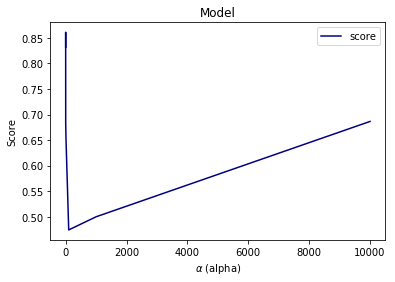

In [23]:
scores = [x[1] for x in gd.grid_scores_]
plt.figure()
plt.title('Model')
plt.xlabel('$\\alpha$ (alpha)')
plt.ylabel('Score')
a = [10**i for i in range(-4,5)]
plt.plot(a,scores, label='score',color='navy')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))

             precision    recall  f1-score   support

   negative       0.46      0.85      0.60      3811
   positive       0.98      0.86      0.91     26189

avg / total       0.91      0.86      0.87     30000



Recall for positive 0.855740959945
Recall for negative 0.854106533718


Precision for postive 0.975791352811
Precision for negative 0.46281814304


# Top 10 important features

In [25]:
index = gd.best_estimator_.coef_.argsort()[:,:-1]

In [27]:
import numpy as np
top_10 = np.take(count_vect.get_feature_names(),index)
print(top_10[0])

['disappoint' 'worst' 'terribl' ..., 'excel' 'delici' 'great']


<h3>SGD Classifier on BOW with hinge loss</h3>
* Optimal alpha = 0.01
* Accuracy = 85.5
* Precision = 0.98(positive), 0.46(negative)
* Recall = 0.86 ,0.85

# SGD Classifier on tfidf

In [35]:
tfidf_vect = TfidfVectorizer()
tfidf_train = tfidf_vect.fit_transform (X_train)
tfidf_test = tfidf_vect.transform(X_test)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean = False)
X_tr = sc.fit_transform(tfidf_train)
X_te = sc.transform(tfidf_test)
gd_tf = GridSearchCV(SGDClassifier(class_weight = 'balanced', loss = 'hinge'),alp,scoring = 'accuracy',cv = 5,n_jobs = -1)
gd_tf.fit(X_tr,y_train)
print(gd_tf.best_params_)
pred = gd_tf.predict(X_te)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)

C:\Users\manish dogra\Documents\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


{'alpha': 10000}
Accuracy is 90.2233333333


C:\Users\manish dogra\Documents\anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


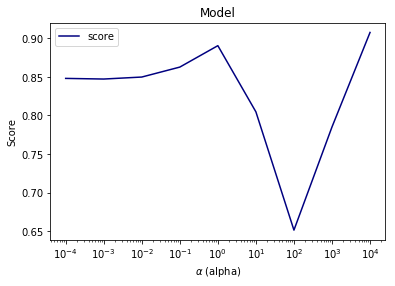

In [36]:
scores = [x[1] for x in gd_tf.grid_scores_]
plt.figure()
plt.title('Model')
plt.xlabel('$\\alpha$ (alpha)')
plt.ylabel('Score')
a = [10**i for i in range(-4,5)]
plt.semilogx(a,scores, label='score',color='navy')
plt.legend()
plt.show()

In [37]:
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))

             precision    recall  f1-score   support

   negative       0.69      0.42      0.52      3811
   positive       0.92      0.97      0.95     26189

avg / total       0.89      0.90      0.89     30000



Recall for positive 0.972736645156
Recall for negative 0.417738126476


Precision for postive 0.919874341012
Precision for negative 0.690372940156


# Top 10 important features

In [38]:
index = gd_tf.best_estimator_.coef_.argsort()[::-1]
top_10 = np.take(tfidf_vect.get_feature_names(),index)
print(top_10[0])

['disappoint' 'worst' 'wast' ..., 'best' 'love' 'great']


<h3>SGD Classifier on TFIDF with hinge loss</h3>
* Optimal alpha = 10000
* Accuracy = 90.22
* Precision = 0.92(positive), 0.69(negative)
* Recall = 0.97 ,0.42

# SGD Classifier on avg w2v

In [39]:
list_of_sent_train = []
for i in X_train:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_train.append(sent)

In [40]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_train,min_count = 5,size = 50,workers = 4)
sent_vectors_train = []
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    sent_vec /= cnt_word
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))

C:\Users\manish dogra\Documents\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


70000


In [41]:
list_of_sent_test = []
for i in X_test:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_test.append(sent)

In [42]:
import warnings
warnings.filterwarnings("ignore")
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_test,min_count = 5,size = 50,workers = 4)
sent_vectors_test = []
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    sent_vec /= cnt_word
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))

30000


In [43]:
np.where(np.isnan(sent_vectors_test))

(array([], dtype=int64), array([], dtype=int64))

In [44]:
sc = StandardScaler()
w2v_train = sc.fit_transform(sent_vectors_train)
w2v_test = sc.transform(sent_vectors_test)
gd_w2v = GridSearchCV(SGDClassifier(class_weight = 'balanced', loss = 'hinge'),alp,scoring = 'accuracy',cv = 5,n_jobs = -1)
gd_w2v.fit(w2v_train,y_train)
print(gd_w2v.best_estimator_)
pred = gd_w2v.predict(w2v_test)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)

SGDClassifier(alpha=10, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy is 87.2933333333


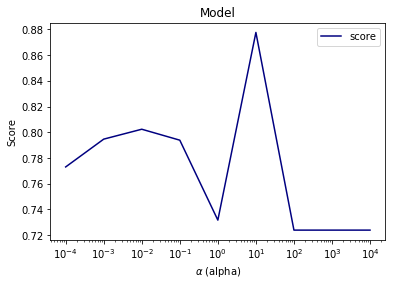

In [45]:
scores = [x[1] for x in gd_w2v.grid_scores_]
plt.figure()
plt.title('Model')
plt.xlabel('$\\alpha$ (alpha)')
plt.ylabel('Score')
a = [10**i for i in range(-4,5)]
plt.semilogx(a,scores, label='score',color='navy')
plt.legend()
plt.show()

In [46]:
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00      3811
   positive       0.87      1.00      0.93     26189

avg / total       0.76      0.87      0.81     30000



Recall for positive 0.99996181603
Recall for negative 0.0


Precision for postive 0.872962432081
Precision for negative 0.0


<h3>SGD Classifier on Avg w2vec with hinge loss</h3>
* Optimal alpha = 10
* Accuracy = 87.29
* Precision = 0.87(positive), 0.0(negative)
* Recall = 1.0 ,0.0

# SGD Classifier on Tfidf w2vec

In [47]:
tf_idf_feat = tfidf_vect.get_feature_names()
tfidf_sent_vec_train = []
row = 0
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec/= weight_sum
    tfidf_sent_vec_train.append(sent_vec)
    row += 1


In [48]:
tf_idf_feat = tfidf_vect.get_feature_names()
tfidf_sent_vec_test = []
row = 0
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec/= weight_sum
    tfidf_sent_vec_test.append(sent_vec)
    row += 1

In [49]:
np.where(np.isnan(tfidf_sent_vec_train))

(array([ 8797,  8797,  8797,  8797,  8797,  8797,  8797,  8797,  8797,
         8797,  8797,  8797,  8797,  8797,  8797,  8797,  8797,  8797,
         8797,  8797,  8797,  8797,  8797,  8797,  8797,  8797,  8797,
         8797,  8797,  8797,  8797,  8797,  8797,  8797,  8797,  8797,
         8797,  8797,  8797,  8797,  8797,  8797,  8797,  8797,  8797,
         8797,  8797,  8797,  8797,  8797, 44257, 44257, 44257, 44257,
        44257, 44257, 44257, 44257, 44257, 44257, 44257, 44257, 44257,
        44257, 44257, 44257, 44257, 44257, 44257, 44257, 44257, 44257,
        44257, 44257, 44257, 44257, 44257, 44257, 44257, 44257, 44257,
        44257, 44257, 44257, 44257, 44257, 44257, 44257, 44257, 44257,
        44257, 44257, 44257, 44257, 44257, 44257, 44257, 44257, 44257, 44257], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 4

In [50]:
y_tr = y_train

In [51]:
del tfidf_sent_vec_train[8797]
y_train = np.delete(y_train,8797)


In [55]:
del tfidf_sent_vec_train[44256]
y_train = np.delete(y_train,44256)

In [56]:
sc =  StandardScaler()
tfidf_w2v_train = sc.fit_transform(tfidf_sent_vec_train)
tfidf_w2v_test = sc.transform(tfidf_sent_vec_test)
gd_wtf = GridSearchCV(SGDClassifier(class_weight = 'balanced', loss = 'hinge'),alp,scoring = 'accuracy',cv = 10,n_jobs = -1)
gd_wtf.fit(tfidf_w2v_train,y_train)
print(gd_wtf.best_params_)
pred = gd_wtf.predict(tfidf_w2v_test)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)

{'alpha': 100}
Accuracy is 87.2966666667


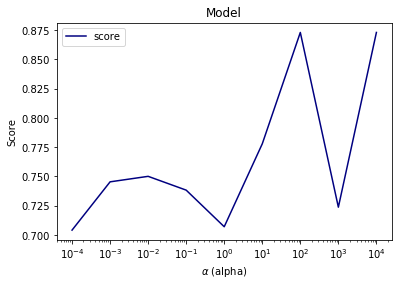

In [57]:
scores = [x[1] for x in gd_wtf.grid_scores_]
plt.figure()
plt.title('Model')
plt.xlabel('$\\alpha$ (alpha)')
plt.ylabel('Score')
a = [10**i for i in range(-4,5)]
plt.semilogx(a,scores, label='score',color='navy')
plt.legend()
plt.show()

In [58]:
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00      3811
   positive       0.87      1.00      0.93     26189

avg / total       0.76      0.87      0.81     30000



Recall for positive 1.0
Recall for negative 0.0


Precision for postive 0.872966666667
Precision for negative 0.0


<h3>SGD Classifier on Tfidf w2vec with hinge loss</h3>
* Optimal alpha = 100
* Accuracy = 87.29
* Precision = 0.87(positive), 0.0(negative)
* Recall = 1.0 ,0.0

<h4>As we came to know that SGD with hinge loss performed well on tfidf so we can apply the SVC with Rbf kernel on Tfidf </h4>

# SVC with Rbf kernel on Tfidf

In [59]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVC(kernel='rbf',class_weight = 'balanced'), param_grid, cv=2,scoring = 'accuracy',n_jobs = -1)
grid_search.fit(X_tr, y_tr)
print(grid_search.best_params_)

{'C': 1, 'gamma': 0.001}


In [60]:
pred = grid_search.predict(X_te)
acc = accuracy_score(y_test,pred)
print("Accuracy is",acc*100)

Accuracy is 87.45


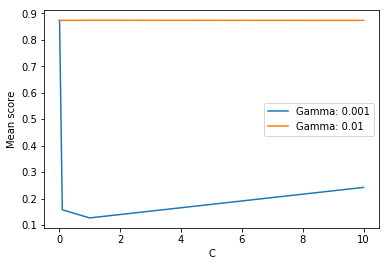

In [65]:
scores = [x[1] for x in grid_search.grid_scores_]
scores = np.array(scores).reshape(len(gammas), len(Cs))

for ind, i in enumerate(gammas):
    plt.plot(Cs, scores[ind], label='Gamma: ' + str(i))
plt.legend()
plt.xlabel('C')
plt.ylabel('Mean score')
plt.show()

In [66]:
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))

             precision    recall  f1-score   support

   negative       0.81      0.02      0.03      3811
   positive       0.87      1.00      0.93     26189

avg / total       0.87      0.87      0.82     30000



Recall for positive 0.999465424415
Recall for negative 0.015743899239


Precision for postive 0.874657488472
Precision for negative 0.810810810811


<h3>SVC on Tfidf with rbf kernel</h3>
* Optimal C and gamma = .001
* Accuracy = 87.45
* Precision = 0.87(positive), 0.81(negative)
* Recall = 1 ,0.02